In [1]:
"""version 2
Part B- Project Simulation
Author:group number 4
        Gefen Maayan, id no 312252794
        Chen Levy, id no 313473993
        Gabriela Agas, id no 313248544 
"""

import numpy as np
import pandas
import simpy
from pylab import plot, show, bar
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import random
import math
import matplotlib.mlab as mlab
import statistics
import csv

In [2]:
# we define a global counter so we can identify the orders.
global counter
counter=0
#a list that keeps the supply time for all the orders
global total_time_lst
total_time_lst=[]
#a list for keeping the times for each iteration
global t_it
t_it=[]

In [3]:
class Order(object):
    def __init__(self,env, shipping_company):
        self.env=env
        global counter
        #use global counter so each order will have unique id number
        counter+=1
        self.id=counter
        #the time the order arrived to our system
        self.arrive_time=0
        #the time the ordered got service
        self.start_service_time=0
        #the day the order arrived
        self.day=0
        p1=np.random.uniform(0,1)
        #10% of the orders are heavy,30% are medium and 60% are small.
        if p1<0.1:
            self.type='heavy'
        elif p1<0.4:
            self.type='medium'
        else:
            self.type='small'
        # if the order came from the center of the city or from the suburbs, we set the location the order came
        p2=np.random.uniform(0,1)
        if p2<0.5: #city center
            self.location_x=np.random.uniform(2,4)
            self.location_y=np.random.uniform(2,4)
        else:      #suburbs
            self.location_x=np.random.uniform(0,6)
            #the x coordinate could be between 0 to 2 or 4 to 6, y coordinate can be between 0 to 6
            if (self.location_x>=0 and self.location_x<2) or (self.location_x>4 and self.location_x<=6):
                self.location_y=np.random.uniform(0,6)
            else: # if the x coordinate between 2 and 4, y coordinate cannot be between 2 to 4 ( it's the center)
                p3=np.random.uniform(0,1)
                if p3<0.5:
                    self.location_y=np.random.uniform(0,2)
                else:
                    self.location_y=np.random.uniform(4,6)

In [4]:
#function that calculate euclidean distance between 2 points
def euclidean_distance(p1,p2):
    distance=math.sqrt(((p1[0]-p2[0])**2)+(p1[1]-p2[1])**2)
    return distance

#function that convert the time to day, assuming we start from day 0(sunday will be 0,monday will be 1 etc..)
def hour_to_day(time):
    day=math.floor(time/24)
    return day

#function that converts the time to the hour in a day, for example:25 will be 1 am
def arrival_hour(time):
    day= hour_to_day(time)
    hour=time
    if day>0:
        hour= time-24*day
    return hour


In [5]:
class Shipping_company(object):
    def __init__(self,env,NUM_BASIC_DRONES,NUM_REGULAR_DRONES,NUM_SUPER_DRONES):
        #define the distribution center object in the shipping company, which located in the center
        self.center=Distribution_center(env, self, 3, 3,NUM_BASIC_DRONES,NUM_REGULAR_DRONES,NUM_SUPER_DRONES)
        #coupons the company will componsate its clients
        self.coupons=0
        #number of shipments that got to the clients not at the same day they ordered it
        self.delay_shipments=0
        #the total time the drones spend on the transportation
        self.total_flight_dist=0
        #dictionary that keeps the supply time for each kind of drone
        self.total_service_time={'Basic':0, 'Regular':0, 'Super':0}
        #--------------------------------------------------------------------------------------------------
        #number of orders in the system
        self.L=0

In [6]:
class Distribution_center(object):
    def __init__(self,env, shipping_company, x, y,NUM_BASIC_DRONES,NUM_REGULAR_DRONES,NUM_SUPER_DRONES):
        #a distribution center has 3 types of drones: basic,regular and super. the amount of the drones from each kind is an input.
        #we define that the drones at the distribution center are our resources, since we supply orders using the drones.
        self.basic_drones = simpy.Resource(env, capacity=NUM_BASIC_DRONES)
        self.regular_drones = simpy.Resource(env, capacity=NUM_REGULAR_DRONES)
        self.super_drones = simpy.Resource(env, capacity=NUM_SUPER_DRONES)
        #the location of the distribution center
        self.location_x=x
        self.location_y=y
        self.no_of_super=NUM_SUPER_DRONES
        self.no_of_reg=NUM_REGULAR_DRONES
        self.no_of_basic=NUM_BASIC_DRONES

In [7]:
def Arrival_Order(env, shipping_company):
    """Create new *order arrivals* until the sim time reaches 120."""
    while True:     
        #initiate a new order object
        new_order = Order(env, shipping_company)
        hour_now=env.now
        #convert the time to an hour in a day
        hour_now = arrival_hour(env.now)
        #if the hour is between 22:00-05:00, there no orders arrivlas
        if hour_now>=22 or (hour_now>=0 and hour_now<5):
            #calculate the time until 5 am
            time_to_pass=hour_now
            if hour_now>=22:
                time_to_pass=math.floor(hour_now-24)
            #make the simulation wait the time until 5am, the time the next order will arrive
            yield env.timeout(5-time_to_pass)
            #update the hour odter waiting
            hour_now=arrival_hour(env.now)
        #update the attribute of the day the order arrived
        new_order.day = hour_to_day(env.now) 
        #if the hour beteen 5am to 10 am, there are 150 arrivales per hour.
        if hour_now>=5 and hour_now<10:
            #update the attribute of time of arrival for the order
            new_order.arrive_time=env.now
            #creating the next arrival
            yield env.timeout(np.random.exponential(1/150))
        #if the hour beteen 10am to 4pm, there are 200 arrivales per hour.
        elif hour_now>=10 and hour_now<16:
            #update the attribute of time of arrival for the order
            new_order.arrive_time=env.now
            #creating the next arrival
            yield env.timeout(np.random.exponential(1/200))
        #if the hour beteen 10am to 4pm, there are 200 arrivales per hour.
        elif hour_now>=16 and hour_now<=22:
            #update the attribute of time of arrival for the order
            new_order.arrive_time=env.now
            #creating the next arrival
            yield env.timeout(np.random.exponential(1/80))
        #the shipping company doesn't get new orders arrivals after thursday at 22:00 (118), so we break the while loop
        if env.now>118:
            break
            
        #-------------------------------------------------------------------------------------            
        #updating the number of orders we have in the system at this point (+order that arrived)
        shipping_company.L+=1
        #appending the number of orders we have to a list
        orders_in.append(shipping_company.L)
        #appending the time that orders_in was updated
        time_orders_in.append(env.now)
            
        #service for the order     
        env.process(Service(env, shipping_company, new_order))

In [8]:
def Service(env,shipping_company,order):
    #calculate the distance from the order location to the distribution center
    euc_distance=euclidean_distance((shipping_company.center.location_x,shipping_company.center.location_y),(order.location_x,order.location_y))
    #calculate the transfer time (distance=speed*time)
    transfer_time=euc_distance/30
    #if the order type is small and all the basic drones are available, 
    #or if the basic&regular drones are occupied-> get service from basic drone
    if order.type=='small' and (shipping_company.center.basic_drones.count<shipping_company.center.no_of_basic or (shipping_company.center.basic_drones.count==shipping_company.center.no_of_basic and shipping_company.center.regular_drones.count==shipping_company.center.no_of_reg)):
        chosen_drone=shipping_company.center.basic_drones
        service_duration=np.random.uniform(1/6,0.5)
        #duration to supply the order
        Duration=transfer_time + service_duration
        #update the total service time for basic drones
        shipping_company.total_service_time['Basic']+=Duration+transfer_time
        #the time the drone will fix itself
        break_p=np.random.uniform(1,3)
            
    #if the order type is small and the regular drone is available and,
    #or if the order is medium and regular&super drones are occupied-> get service from medium drone
    elif (order.type=='small' and shipping_company.center.regular_drones.count<shipping_company.center.no_of_reg) or (order.type=='medium' and (shipping_company.center.regular_drones.count<shipping_company.center.no_of_reg or (shipping_company.center.regular_drones.count==shipping_company.center.no_of_reg and shipping_company.center.super_drones.count==shipping_company.center.no_of_super))):
        chosen_drone=shipping_company.center.regular_drones
        service_duration=(1/12)+np.random.exponential(1/12)
        #duration to supply the order
        Duration=transfer_time + service_duration
        #update the total service time for regular drones
        shipping_company.total_service_time['Regular']+=Duration+transfer_time
        #the time the drone will fix itself
        break_p=np.random.triangular(2,3,6)
   #if the super drone is available and the order type is medium,
    #or if the order is heavy -> get service from super drone         
    elif order.type=='heavy' or (shipping_company.center.super_drones.count<shipping_company.center.no_of_super and  order.type=='medium'):
        chosen_drone=shipping_company.center.super_drones
        #duration to supply the order
        service_duration=(1/6)+np.random.exponential(1/6)
        Duration=transfer_time + service_duration
        #update the total service time for super drones
        shipping_company.total_service_time['Super']+=Duration+transfer_time
        #the time the drone will fix itself
        break_p=np.random.triangular(2,4,8)
    #service the order with the chosen center and the chosen kind of drone
    with chosen_drone.request() as resource:
        yield resource
        #update the available counter which presents how many drones are available to give service from each kind
        #update the attribute of the time the order start service 
        order.start_service_time=env.now
        yield env.timeout(Duration)
        #------------------------------------------------------------------------------------------------
        #updating the number of orders we have in the system at this point (-order that we supplied)
        shipping_company.L-=1
        #appending the number of orders we have to a list
        orders_in.append(shipping_company.L)
        #appending the time that orders_in was updated
        time_orders_in.append(env.now)
        #the day the client finished sevice and gets his order include the transfer and the service time
        supply_day=hour_to_day(env.now)
        #the drone get from the order location back to the distribution center
        yield env.timeout(transfer_time)  
        #the probability that a drone will break is 10%. if the drone broke after it finished it's assignment
        #we use timeout so the drone is "occupied" by fixing itself.
        x=np.random.uniform(0,1)
        if x<0.1:
            yield env.timeout(break_p)
    
    #the time the client waited in queue is the differnec between the time the order start getting service and the time the order arrived
    waiting_queue_time=order.start_service_time-order.arrive_time
    #the total time to service the order is the time the client waited plus the transfer and service time
    total_waiting_time=Duration+waiting_queue_time
    # if the time to supply the client's order is more than 2 hours, we componsate the client. 
    if total_waiting_time>2:
        #we define linear coupon for each customer who waits more than 2 hours
        shipping_company.coupons+=50*(total_waiting_time-2)
        #--------------------------------------------------------------------------------------------
        if order.type=='small':
            delayed_types[0]+=1
        elif order.type=='medium':
            delayed_types[1]+=1
        else:
            delayed_types[2]+=1
        pie_orders[0]+=1
    else:
        pie_orders[1]+=1
    #if a client recieves his order not the same they he ordered it
    if supply_day>order.day:
        shipping_company.delay_shipments+=1
    #the total flight distance the drone did
    shipping_company.total_flight_dist+=2*euc_distance
    #the total time the client waited for the order including waiting  in queue,transfer and service.
    global total_time_lst
    total_time_lst.append(total_waiting_time)
    #same time, but the list will keep it to each iteration
    global t_it
    t_it.append(total_waiting_time)

In [9]:
global t_it
#initiate a list that will contain the average supply time for each iteration
total_t_it=[]
#number of distribution centers 
NUM_DES_CENTER = 1
#number of drones for the distribution center
NUM_BASIC_DRONES = 86
NUM_REGULAR_DRONES = 28
NUM_SUPER_DRONES = 4
#fixed costs depends on the number of drones from each kind.
fixed_costs =NUM_DES_CENTER*(10000*NUM_BASIC_DRONES+15000*NUM_REGULAR_DRONES+30000*NUM_SUPER_DRONES)
global total_time_lst
#initiate empty lists for saving values for 150 iterations so we can use mean for better measure
#list we will save for each iteration the total cost
TC2_lst=[]
#list we will save for each iteration the number of delayed shimpents( didnt arrive the same day ordered)
Delay2=[]
#list we will save for each iteration the cost for flights(transfers back and forth)
DF2=[]
#list we will save for each iteration the operation cost( flights and service costs)
Operation_Costs2=[]
#list we will save for each iteration the coupons cost
Coupons_lst2=[]
#list we will save for each iteration the number of orders
Num_of_orders2=[]
#we call the global counter so we can use it for counting number of orders each iteration
global counter
seed_lst= [i for i in range (150)] # random seed for the iterations
#---------------------------------------------------------------------------------------
# Empty lists for graphs
time_orders_in=[]
orders_in=[]
delayed_types=[0,0,0] #[small,medium,heavy]
costs=[0,0,0] #[coupon costs, flight costs, service costs]
pie_orders=[0,0] #[delayed more than 2 hours, not delayed]
#run the simulation 150 times for the new policy
for i in range (150):
    #initiate the supply time list for each iteration
    t_it=[]
    np.random.seed(seed_lst[i]) #we initialize random seed for each itration in order to compere between the configurations
    #for each iteration, we reset the counter
    counter=0
    # Setup and start the simulation
    env = simpy.Environment()
    # Create shipping_company (the _Init_ function) for the new policy
    s2 = Shipping_company(env,NUM_BASIC_DRONES,NUM_REGULAR_DRONES,NUM_SUPER_DRONES)
    # Start process and run
    env.process(Arrival_Order(env, s2))
    env.run()
    #total time took the drone for each kind of drone
    TB2=s2.total_service_time['Basic']
    TR2=s2.total_service_time['Regular']
    TS2=s2.total_service_time['Super']
    #calculate the cost of the flights(transfers)
    direct_flight_costs = 0.1*s2.total_flight_dist
    DF2.append(direct_flight_costs)
    #calculate service costs
    direct_service_costs= 100*TB2 +130*TR2 +180*TS2
    Operation_Costs2.append(direct_flight_costs+direct_service_costs)
    coupons_costs= s2.coupons
    Coupons_lst2.append(coupons_costs)
    #calculate total costs
    costs_sum= fixed_costs+direct_flight_costs+direct_service_costs+coupons_costs
    TC2_lst.append(costs_sum)
    Delay2.append(s2.delay_shipments)
    Num_of_orders2.append(counter)
    total_t_it.append(statistics.mean(t_it))
    #-----------------------------------------------------------------------------------
    costs[0]=coupons_costs
    costs[1]=direct_flight_costs
    costs[2]=direct_service_costs    

print ("The average number of orders:" ,statistics.mean(Num_of_orders2)) 
print ("The average supply time:" ,statistics.mean(total_time_lst))       
print ("The average number of shipments that did not arrive the same day they ordered:" ,statistics.mean(Delay2))  
print ("The average flight costs:" ,statistics.mean(DF2))  
print ("The average operation costs:" ,statistics.mean(Operation_Costs2)) 
print ("The average coupon costs:" ,statistics.mean(Coupons_lst2)) 
print ("The average total costs:" ,statistics.mean(TC2_lst)) 

The average number of orders: 12156.493333333334
The average supply time: 8.687988967381909
The average number of shipments that did not arrive the same day they ordered: 1130.4066666666668
The average flight costs: 3899.3254702621407
The average operation costs: 551087.2334464593
The average coupon costs: 4836801.277977259
The average total costs: 6787888.511423718


In [10]:
"""export the times to csv file for anova investigation"""
#create the csv data file:
with open('version_2.csv', mode='w', newline='') as version_2:
    version_2_writer = csv.writer(version_2, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    version_2_writer.writerow(["iteration", "supply_time"])
    for i in range(len(total_t_it)):
        version_2_writer.writerow([i, total_t_it[i]])


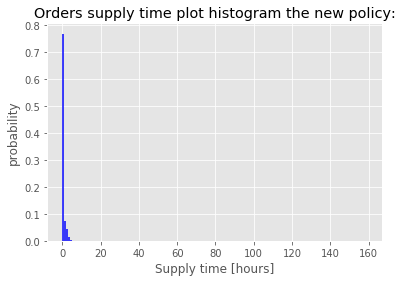

In [11]:
#histogram-graph to show the scattering of supply time
num_bins = [i for i in range (160)]
global total_time_lst
n, bins, patches = plt.hist(total_time_lst,num_bins, weights=np.ones_like(total_time_lst) / len(total_time_lst),
                            facecolor='blue', alpha=0.75)
plt.xlabel('Supply time [hours]')
plt.ylabel('probability')
plt.title('Orders supply time plot histogram the new policy:')
plt.show()

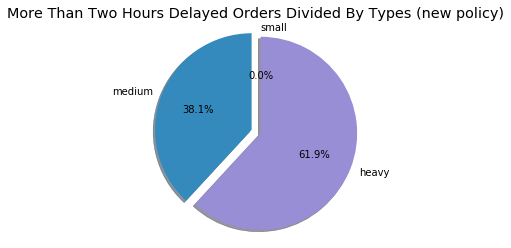

In [12]:
#pie graph that shows number of more than 2 hours delayed orders divided by types
#for 150 weeks
labels='small','medium','heavy'
sizes=delayed_types
explode=(0,0.1,0)
plt.title('More Than Two Hours Delayed Orders Divided By Types (new policy)')
plt.pie(sizes,explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

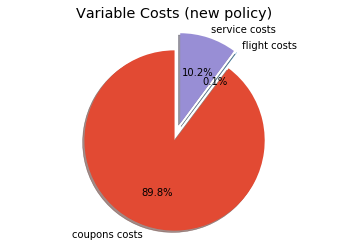

In [13]:
#pie graph that shows variable costs divided by coupons costs, flight costs and service costs
#for 150 weeks
labels='coupons costs','flight costs','service costs'
sizes=costs
explode=(0.1,0.1,0.1)
plt.title('Variable Costs (new policy)')
plt.pie(sizes,explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

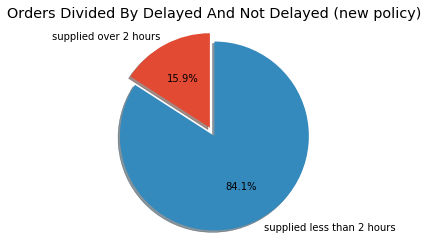

In [14]:
#pie graph that shows percentage of more than 2 hours delayed orders out of all the orders
#for 150 weeks
labels='supplied over 2 hours','supplied less than 2 hours'
sizes=pie_orders
explode=(0.1 ,0)
plt.title('Orders Divided By Delayed And Not Delayed (new policy)')
plt.pie(sizes,explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()